# **NEURAL VISUAL DECODING with fMRI**
**Final Project -** \\
Salvatore Falciglia at Sapienza University of Rome, A.Y. 2022/2023

Reference paper: [**Reconstructing seen image from brain activity by visually-guided cognitive representation and adversarial learning (2021)**](https://www.sciencedirect.com/science/article/pii/S1053811920310879)

In [ ]:
! pip install --quiet pytorch-lightning

In [ ]:
'''#############################################################'''
'''#################### Importing libraries ####################'''
'''#############################################################'''

import torch
import torch.utils
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn as nn
import torch.nn.functional as Functional
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.utils as utils

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.callbacks import Callback

import numpy as np
from scipy import signal
from scipy.signal import butter, lfilter
from scipy.stats import entropy
import math
import random
from skimage.transform import resize

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import copy

import sys, os, time
import scipy.io as io
import scipy.stats as stats

import seaborn as sns
from PIL import Image

from torchmetrics import StructuralSimilarityIndexMeasure

SEED = 2206

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## **INTRODUCTION**

Visual neural decoding, or the ability to interpret external visual stimuli from patterns of brain activity, is a challenging task in neuroscience research. Recent advances in generative deep learning methods have made it possible to decode brain activity patterns and reconstruct visual stimuli from the neural response they evoke. In this work, I propose a re-implementation from scratch of the architecture presented in [[1]](https://www.sciencedirect.com/science/article/pii/S1053811920310879), dealing with the training process of the **VAE-GAN model** on which the implemented architecture is based.

### **A message for the Professors**

Pytorch Lightning has been used for this re-implementation. Anyway, since I had to work with multiple optimizers at the same time, the training and optimization processes have been managed manually.
All experiments have been conducted using a V100 GPU with 32 GB of Virtual RAM (VRAM), from INFN, kindly made available by Professor Stefano Giagu.

Moreover, *cuda* and *cuDNN* gave problems to run convolutions due to their versions and compatibility. I tried to disable cuDNN, by setting the *torch.backends.cudnn.enabled* flag to *False*, but this really slower training performances. Eventually, only with one dataset (out of all the datasets exploited in the [**reference paper**](https://www.sciencedirect.com/science/article/pii/S1053811920310879)),  I managed to train efficiently the entire architecture by adjusting the *batch_size* and by choosing proper optimizers.

*Finally, I'm currently working on efficiently training the architecture on two other datasets, one of which is cited in the reference paper (namely the 'BRAINS' dataset), and the other is on natural images (namely the [Kay Dataset](https://www.nature.com/articles/nature06713)). My aim would be to include this work as part of my Master's thesis.*

## **RELATED WORKS**

Recent studies have used fMRI signals from early visual areas to perform visual neural decoding, using the voxel as the basic unit of measurement, the analog of a pixel on a regular grid in three-dimensional space. Kay et al.'s basic idea presented in [[2]](https://www.nature.com/articles/nature06713), together with their own dataset of natural images on which they achieved 90\% accuracy, was to model the responses to each individual image as a weighted sum of simple image filters responses, called **Gabor Wavelet Pyramids**, and then to evaluate the trained model by asking whether it is possible to identify a novel image that a subject is looking at from a set of possible images. Naselaris et al. proposed in 2009 a new **Bayesian decoder** that uses fMRI signals from early and anterior visual areas to reconstruct complex natural images [[3]](https://pubmed.ncbi.nlm.nih.gov/19778517/). In a more recent work [[4]](https://www.biorxiv.org/content/10.1101/2022.11.18.517004v3) Takagi and Nishimoto proposed a new method based on a **diffusion model (DM)** to reconstruct images from human brain activity obtained via fMRI.

A systematic review published in *Frontiers in Neuroscience* [[5]](https://www.frontiersin.org/articles/10.3389/fnins.2021.795488/full) in 2021 survey the most recent deep learning methods for natural image reconstruction from fMRI.
A group of studies by Seeliger et al. (2018), Mozafari et al. (2020), and Qiao et al. (2020) utilized **GAN** architecture with the assumption that there is a linear relationship between brain activity and the latent features of GAN.
Seeliger et al. (2018) used a **deep convolutional GAN (DCGAN)** architecture (Radford et al., 2016), which introduced improvements by stacking convolutional and deconvolutional layers. The authors learn the direct linear mapping from the fMRI space to the latent space of GAN.
Mozafari et al. (2020) used a variation of GAN, called the **BigBiGAN model** (Donahue and Simonyan, 2019), which allowed the reconstruction of even more realistic images. The model generates high-level semantic information due to the BigBiGAN’s latent space, which extracts high-level image details from fMRI data.
A group of studies on reconstructing natural images from brain activity patterns, including Ren et al. (2021) and VanRullen and Reddy (2019), incorporated probabilistic inference using **VAE-GAN**. In a recent work by Ren et al. (2021), the authors presented a combined network called **Dual-Variational Autoencoder/ Generative Adversarial Network (D-VAE/GAN)**.

## **BLOCKS DEFINITION**

### **DATASET**

This dataset is referred to as 69 dataset [[6]](https://pubmed.ncbi.nlm.nih.gov/20858128/), which contains one participant presented a hundred of handwritten
gray-scale digits (6 s and 9 s) with the size of 28×28. Each character
remained visible for 12.5 s and flickered at a rate of 6 Hz, with fixation,
in a 3T scanner (TR, 2.5 s; voxel size, 2×2×2 mm). The images are taken
from the training set of the MNIST and the fMRI data are taken from V1,
V2, and V3. Following the original train/test set split, ninety stimulusfMRI paired examples are used for training and the rest for validation.

In [ ]:
'''#############################################################'''
'''################### Dataset & Data Module ###################'''
'''#############################################################'''

class MNIST69_Dataset(Dataset):

    def __init__(self,
                 batch_size,
                 mode,
                 data_folder):
        self.batch_size = batch_size
        self.mode = mode
        self.data_folder = data_folder

        self.dataset = self.open_dataset(self.data_folder, self.mode)

        self.transform = transforms.Compose([transforms.Resize(64),
                                            transforms.CenterCrop(64),
                                            #transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5),(0.5))])


    def open_dataset(self, folder, mode):
        MNIST69_DATASET = []
        mat = io.loadmat(folder)
        class_6 = []
        class_9 = []
        progress_bar = tqdm(range(100))
        for i in range(100):
            single_recording = {'fMRIdata': mat['Y'][i],
                                'image': mat['X'][i],
                                'label': int(mat['labels'][i])}
            if int(mat['labels'][i]) == 1:
              class_6.append(i)
            elif int(mat['labels'][i]) == 2:
              class_9.append(i)

            MNIST69_DATASET.append(single_recording)
            progress_bar.update()

        # Shuffle the original list indices
        random.shuffle(class_6)
        random.shuffle(class_9)
        # Calculate the split indices
        split_6 = int(len(class_6) * 0.9)
        split_9 = int(len(class_9) * 0.9)
        list_idx_class6_train = class_6[:split_6]
        list_idx_class6_val = class_6[split_6:]
        list_idx_class9_train = class_9[:split_9]
        list_idx_class9_val = class_9[split_9:]
        # Split the list
        data_list = []
        if mode == 'train':
          for idx in list_idx_class6_train:
              data_list.append(MNIST69_DATASET[idx])
          for idx in list_idx_class9_train:
              data_list.append(MNIST69_DATASET[idx])
        elif mode == 'val':
          for idx in list_idx_class6_val:
              data_list.append(MNIST69_DATASET[idx])
          for idx in list_idx_class9_val:
              data_list.append(MNIST69_DATASET[idx])
        elif mode == 'test':
          for idx in list_idx_class6_val:
              data_list.append(MNIST69_DATASET[idx])
          for idx in list_idx_class9_val:
              data_list.append(MNIST69_DATASET[idx])

        return data_list


    def __getitem__(self, index):

        if self.mode == 'train':
          # Take one recording from the dataset
          recording_dictionary = self.dataset[index]
          # Extract the Image [image of size (28,28)]
          image = recording_dictionary['image'].reshape(28, 28, order='F')
          #image = resize(image, (100, 100), anti_aliasing=True)
          #image = torch.tensor(image)
          image = Image.fromarray(image)
          image = self.transform(image)
          # Extract the EEG Recording [tensor of size [N,T]]
          recording_fMRI = torch.tensor(recording_dictionary['fMRIdata'])

          return image, recording_fMRI

        elif self.mode == 'val':
          # Take one recording from the dataset
          recording_dictionary = self.dataset[index]
          # Extract the Image [image of size (28,28)]
          image = recording_dictionary['image'].reshape(28, 28, order='F')
          #image = resize(image, (100, 100), anti_aliasing=True)
          #image = torch.tensor(image)
          image = Image.fromarray(image)
          image = self.transform(image)
          # Extract the EEG Recording [tensor of size [N,T]]
          recording_fMRI = torch.tensor(recording_dictionary['fMRIdata'])

          return image, recording_fMRI

        elif self.mode == 'test':
          # Take one recording from the dataset
          recording_dictionary = self.dataset[index]
          # Extract the Image [image of size (28,28)]
          image = recording_dictionary['image'].reshape(28, 28, order='F')
          #image = resize(image, (100, 100), anti_aliasing=True)
          #image = torch.tensor(image)
          image = Image.fromarray(image)
          image = self.transform(image)
          # Extract the EEG Recording [tensor of size [N,T]]
          recording_fMRI = torch.tensor(recording_dictionary['fMRIdata'])

          return image, recording_fMRI


    def __len__(self):
        return len(self.dataset)


    def vismnist_collate_fn(self, data_batch):

        data_batch.sort(key=lambda d: len(d[1]), reverse=True)
        imgs, recording_fMRI = zip(*data_batch)

        imgs = torch.stack(imgs, dim=0)
        recordings_fMRI = torch.stack(recording_fMRI, dim=0)

        return imgs, recordings_fMRI


class MNIST69_Data_Module(pl.LightningDataModule):

    def __init__(self,
                 batch_size,
                 data_folder):
        super().__init__()
        self.batch_size = batch_size
        self.data_folder = data_folder


    def setup(self, stage=None):
        if stage in (None, 'fit'):
          self.train_ds = MNIST69_Dataset(mode='train', batch_size=self.batch_size, data_folder=self.data_folder)
          self.val_ds = MNIST69_Dataset(mode='val', batch_size=self.batch_size, data_folder=self.data_folder)
        if stage == 'predict':
          self.test_ds = MNIST69_Dataset(mode='test', batch_size=1, data_folder=self.data_folder)


    def train_dataloader(self):
        return DataLoader(dataset=self.train_ds,
                          num_workers=2,
                          batch_size=self.batch_size,
                          collate_fn=self.train_ds.vismnist_collate_fn,
                          shuffle=True)


    def val_dataloader(self):
        return DataLoader(dataset=self.val_ds,
                          num_workers=2,
                          batch_size=self.batch_size,
                          collate_fn=self.val_ds.vismnist_collate_fn,
                          shuffle=False)


    def test_dataloader(self):
        return DataLoader(dataset=self.test_ds,
                          batch_size=self.test_ds.batch_size,
                          num_workers=2,
                          shuffle=False)

### **ARCHITECTURE MODULES**

The architecture proposed in the [**chosen reference paper**](https://www.sciencedirect.com/science/article/pii/S1053811920310879) presents four modules. The few details given in the text are all reported in the following blocks-scheme, with layers sizes thought for images (visual stimuli) resized to 100 × 100 for training and evaluation. \\

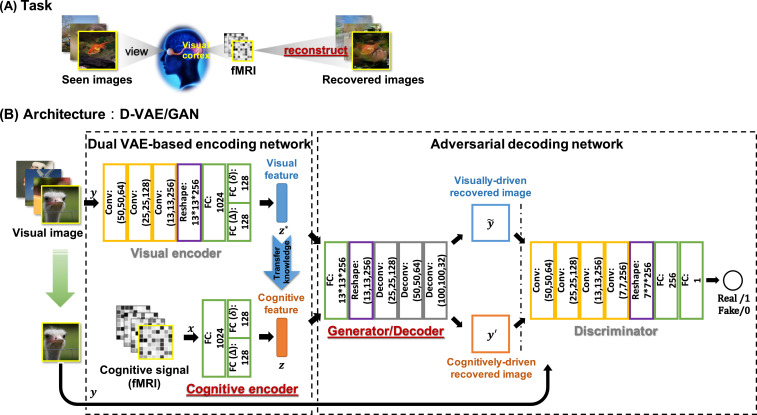


In this proposed re-implementation I applied **non-linearities** between layers and **batch normalization** layers as a regularization technique, trying to improve the generalization performance. Moreover, images have been **resized to 64x64** for training and evaluation.

#### **Visual and Cognitive Encoders**

By introducing two encoders in the framework, a dual encoding network architecture is defined. Both the Visual Encoder $E_{Vis}$ and the Cognitive Encoder $E_{Cog}$ represent a parametric inference model, $q_{\Phi^{'}}(z^*|y)$ and $q_{\Phi^{''}}(z|x)$ respectively, with their own variational parameters $\Phi^{'}$ and $\Phi^{''}$. \\

$E_{Cog}$ is a simple MLP, with three FC Layers, taking in input a 1D signal, the cognitive pattern (i.e, the fMRI signal). $E_{Vis}$, compared to the previous encoder, adds at the beginning three additional Conv2d Layers in order to deal with the 2D input images, the visual stimuli. \\

Through the **reparameterization trick**, the randomness in $z$ is externalized by re-parametrizing the variable as a deterministic and differentiable function of their own inputs and variational parameters, plus a newly introduced random variable $\epsilon$.

In [ ]:
'''#############################################################'''
'''###################### Visual Encoder #######################'''
'''#############################################################'''

class VisualEncoder(nn.Module):
    def __init__(self, num_channels=1, num_features=8*8*256, z_dim=128):
        super(VisualEncoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=5, stride=2, padding=2) # (50,50,64) # (32,32,64)
        self.bn1 = nn.BatchNorm2d(64, momentum=0.9)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=2) # (25,25,128) # (16,16,128)
        self.bn2 = nn.BatchNorm2d(128, momentum=0.9)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=2, padding=2) # (13,13,256) # (8,8,256)
        self.bn3 = nn.BatchNorm2d(256, momentum=0.9)

        self.fc1 = nn.Linear(in_features=num_features, out_features=2048)
        self.bn4 = nn.BatchNorm1d(2048,momentum=0.9)
        self.fc2 = nn.Linear(in_features=2048, out_features=z_dim)
        self.fc3 = nn.Linear(in_features=2048, out_features=z_dim)

        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        #x = x.unsqueeze(dim=1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)

        x = self.conv3(x) # (13,13,256)
        x = self.bn3(x)
        x = self.leaky_relu(x)

        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.leaky_relu(x)

        mu = self.fc2(x)
        logvar = self.fc3(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std


In [ ]:
'''#############################################################'''
'''##################### Cognitive Encoder #####################'''
'''#############################################################'''

class CognitiveEncoder(nn.Module):
    def __init__(self, num_features=8428, z_dim=128):
        super(CognitiveEncoder, self).__init__()

        self.fc1 = nn.Linear(in_features=num_features, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=z_dim)
        self.fc3 = nn.Linear(in_features=1024, out_features=z_dim)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        x = x.float()
        x = self.fc1(x)
        mu = self.fc2(x)
        logvar = self.fc3(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std


#### **Generator**

Here, the VAE Decoder and the GAN generator are integrated, sharing the same parameters and leading us to talk about the VAE-GAN architecture. Moreover, since this generator tries to reconstruct the corresponding visual stimulus $y$ starting from features in $z$ and $z^*$, our final architecture is a (Dual) D-VAE/GAN.

In [ ]:
'''#############################################################'''
'''######################### Generator #########################'''
'''#############################################################'''

class Generator(nn.Module):
    def __init__(self, input_size=128):
        super(Generator, self).__init__()
        self.fc = nn.Linear(input_size, 8 * 8 * 256)
        self.bn1 = nn.BatchNorm1d(8 * 8 * 256, momentum=0.9)
        self.deconv1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=6, stride=2, padding=2) # (25,25,256)
        self.bn2 = nn.BatchNorm2d(256, momentum=0.9)
        self.deconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=6, stride=2, padding=2) # (50,50,128)
        self.bn3 = nn.BatchNorm2d(128, momentum=0.9)
        self.deconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=6, stride=2, padding=2) # (100,100,32)
        self.bn4 = nn.BatchNorm2d(32, momentum=0.9)
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=5, stride=1, padding=2) # (100,100,1)
        self.tanh = nn.Tanh()

        self.relu = nn.ReLU(True)

    def forward(self, x):
        x = x.float()
        x = self.fc(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = x.reshape(-1, 256, 8, 8)

        x = self.deconv1(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.deconv2(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.deconv3(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = self.deconv4(x)
        x = self.tanh(x)
        return x #.squeeze()


#### **Discriminator**

The GAN implemented here is a deep convolutional GAN (DCGAN). It uses batch normalization in most layers of both the discriminator and the generator, as a way to prevent mode collapse. Only the last layer of the generator and the first layer of the discriminator are not batch normalized, so that the model can learn the correct mean and scale of the data distribution. \\
The activation functions used are the ReLU for the Generator and the LeakyReLU for the Discriminator. Moreover, the output non-linearities adopted are Tanh for the Generator and Sigmoid for the Discriminator.

In [ ]:
'''#############################################################'''
'''####################### Discriminator #######################'''
'''#############################################################'''

class Discriminator(nn.Module):
    def __init__(self, num_features=8*8*256):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2) # (100,100,32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=5, stride=2, padding=2) # (50,50,128)
        self.bn1 = nn.BatchNorm2d(128, momentum=0.9)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=2, padding=2) # (25,25,256)
        self.bn2 = nn.BatchNorm2d(256, momentum=0.9)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, stride=2, padding=2) # (13,13,256)
        self.bn3 = nn.BatchNorm2d(256, momentum=0.9)

        self.fc1 = nn.Linear(in_features=num_features, out_features=512)
        self.bn4 = nn.BatchNorm1d(512,momentum=0.9)
        self.fc2 = nn.Linear(in_features=512, out_features=1)
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.float()
        #x = x.unsqueeze(dim=1)
        x = self.conv1(x)
        x = self.leaky_relu(x)

        x = self.conv2(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)

        x = self.conv3(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)

        x = self.conv4(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)

        x = x.reshape(x.shape[0], -1)
        fs = x
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.leaky_relu(x)

        x = self.fc2(x)
        x = self.sigmoid(x)

        return x, fs

### **PROPOSED ARCHITECTURE**

As proposed in the reference paper, a three-stage training method is used to
train the model in a gradual fashion. See figure.

**Stage I** \\
In the first stage, we perform an ***intra-modality reconstruction task*** (within the same modality) for learning the latent visual representations,
no fMRI responses involved.

**Stage II** \\
In the second stage, we perform an ***inter-modality knowledge distillation task*** that forces the cognitive encoder to mimic the visual encoder, so as to
capture more visually important features in the latent cognitive space.
Intuitively, it makes sense that $𝐸_{Vis}$ is more capable of capturing visually important features for the visual stimuli reconstruction since it
learns latent representation within the same modality. Therefore, we
treat $𝐸_{Vis}$ as a teacher network and $𝐸_{Cog}$ as a student network, and train $𝐸_{Cog}$ to mimic $𝐸_{Vis}$ so as to better capture visually-related information from noise brain signals.

**Stage III** \\
Finally, in the third stage, we perform a ***fine-tuning task*** to slightly
update the network parameters $\eta$ of the generator $𝐺$ such that it can
become more capable of recovering the visual stimuli when given latent
cognitive feature $𝐳$.

This three-stage training method is carefully designed to mitigate the
gap between source and target domains in the training process.



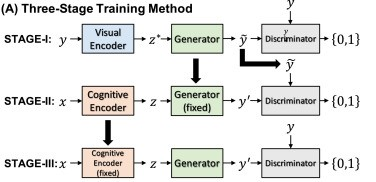



The training strategy has been the most challenging part, trying to effectively and efficently train the two VAE-GAN architectures, considering *the visual_encoder + the generator* and *the cognitive_encoder + the generator*. Moreover, *cuda* and *cuDNN* gave problems to run convolutions due to their versions and compatibility. I tried to disable cuDNN, by setting the *torch.backends.cudnn.enabled* flag to *False*, but this really slower training performances. Eventually, by adjusting the *batch_size* and by choosing the optimizers, I managed to train efficacely the entire architecture. Here the implementation details:


1.   *batch_size = 5*
2.   **STAGE I.** Three optimizers used. Number of training epochs 1000. \\
**Discriminator** --> *RMSprop*, *lr=3e-5* \\
**Generator** --> *RMSprop*, *lr=3e-4* \\
**Encoder** --> *RMSprop*, *lr=3e-4*
3.   **STAGE II.** Two optimizers used. Number of training epochs 1000. \\
**Discriminator** --> *RMSprop*, *lr=3e-4* \\
**Encoder** --> *RMSprop*, *lr=3e-4* \\

As I will specify in the Results section, I reached better results in reconstructing images (visual stimuli) starting from the fMRI data, without entering in the stage III of the proposed training strategy. Anyway, in the performed experiments, implemetnation details for stage III are as follows:

4.   **STAGE III.** Two optimizers used. Number of training epochs 100. \\
**Discriminator** --> *RMSprop*, *lr=3e-4* \\
**Generator** --> *RMSprop*, *lr=3e-4* \\

\\

The number of training epochs for each stage has been chosen by evaluating the image reconstruction obtained as output from the architecture, respectively for all three stages.

In [ ]:
'''#############################################################'''
'''################# The Proposed Architecture #################'''
'''#############################################################'''

class NeuralVisualDecodingfMRIModel(pl.LightningModule):

    def __init__(self,
                 visualencoder_hyperparameters,
                 cognitivencoder_hyperparameters,
                 generator_hyperparameters,
                 discriminator_hyperparameters):
        super(NeuralVisualDecodingfMRIModel, self).__init__()
        self.automatic_optimization = False

        # ---- Visual Encoder Hyperparameters --------------------------------------------------------------
        self.ve_num_channels = visualencoder_hyperparameters['num_channels']
        self.ve_num_features = visualencoder_hyperparameters['num_features']
        self.ve_z_dim = visualencoder_hyperparameters['z_dim']
        # ---- Cognitive Encoder Hyperparameters -----------------------------------------------------------
        self.ce_num_features = cognitivencoder_hyperparameters['num_features']
        self.ce_z_dim = cognitivencoder_hyperparameters['z_dim']
        # ---- Generator Hyperparameters -------------------------------------------------------------------
        self.g_input_size = generator_hyperparameters['input_size']
        # ---- Discriminator Hyperparameters ---------------------------------------------------------------
        self.d_num_features = discriminator_hyperparameters['num_features']

        self.visual_encoder = VisualEncoder(self.ve_num_channels, self.ve_num_features, self.ve_z_dim)
        self.cognitive_encoder = CognitiveEncoder(self.ce_num_features, self.ce_z_dim)
        self.generator = Generator(self.g_input_size)
        self.discriminator = Discriminator(self.d_num_features)

        self.visual_encoder.apply(self.weights_init)
        self.cognitive_encoder.apply(self.weights_init)
        self.generator.apply(self.weights_init)
        self.discriminator.apply(self.weights_init)

        self.criterion = nn.BCELoss()
        self.gamma = 15

    def forward(self, x):
        # Cognitive Encoder
        z_cog, _, _ = self.cognitive_encoder(x)
        #z_vis, _, _ = self.visual_encoder(x)
        # Generator
        fMRI_reconstruction = self.generator(z_cog)
        return fMRI_reconstruction

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def configure_optimizers(self):
        stage1_discriminator_optimizer = torch.optim.RMSprop(list(self.discriminator.parameters()), lr=3e-5) #, betas=(0.5, 0.999), weight_decay=0.98)
        stage1_generator_optimizer = torch.optim.RMSprop(list(self.generator.parameters()), lr=3e-4) #, betas=(0.5, 0.999), weight_decay=0.98)
        stage1_encoder_optimizer = torch.optim.RMSprop(list(self.visual_encoder.parameters()), lr=3e-4) #, betas=(0.5, 0.999), weight_decay=0.98)

        stage2_discriminator_optimizer = torch.optim.RMSprop(list(self.discriminator.parameters()), lr=3e-4) #, betas=(0.9, 0.999), weight_decay=0.98)
        stage2_encoder_optimizer = torch.optim.RMSprop(list(self.cognitive_encoder.parameters()), lr=3e-4) #, betas=(0.9, 0.999), weight_decay=0.98)

        stage3_discriminator_optimizer = torch.optim.RMSprop(list(self.discriminator.parameters()), lr=3e-4) #, betas=(0.9, 0.999), weight_decay=0.98)
        stage3_generator_optimizer = torch.optim.RMSprop(list(self.generator.parameters()), lr=3e-4) #, betas=(0.9, 0.999), weight_decay=0.98)

        return stage1_discriminator_optimizer, stage1_generator_optimizer, stage1_encoder_optimizer, stage2_discriminator_optimizer, stage2_encoder_optimizer, stage3_discriminator_optimizer, stage3_generator_optimizer

    def training_step(self, train_batch, batch_idx):
        # Access the current epoch number
        current_epoch = self.trainer.current_epoch

        stage1_discriminator_optimizer, stage1_generator_optimizer, stage1_encoder_optimizer, stage2_discriminator_optimizer, stage2_encoder_optimizer, stage3_discriminator_optimizer, stage3_generator_optimizer = self.optimizers()
        torch.set_grad_enabled(True)

        imgs, recordings_fMRI = train_batch
        imgs, recordings_fMRI = imgs.to(device), recordings_fMRI.to(device)
        bs = imgs.shape[0]

        if current_epoch < 400:
          '''######################### S T A G E 1 #########################'''
          ## ------------------- TRAIN THE DISCRIMINATOR ----------------------
          ones_label = torch.ones(bs, 1).to(device)
          zeros_label = torch.zeros(bs, 1).to(device)
          zeros_label_noise = torch.zeros(bs, 1).to(device)

          z_vis, _, _ = self.visual_encoder(imgs)
          image_reconstruction = self.generator(z_vis)
          z_noise = torch.randn(bs, 128).to(device)
          rec_noise = self.generator(z_noise)

          output = self.discriminator(imgs)[0]
          errD_real = self.criterion(output, ones_label)
          output = self.discriminator(image_reconstruction)[0]
          errD_rec_enc = self.criterion(output, zeros_label)
          output = self.discriminator(rec_noise)[0]
          errD_rec_noise = self.criterion(output, zeros_label_noise)

          discriminator_loss_value = errD_real + errD_rec_enc + errD_rec_noise
          self.log('train loss discriminator', discriminator_loss_value, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
          if batch_idx==109:
                print('train loss discriminator\t',  discriminator_loss_value)

          stage1_discriminator_optimizer.zero_grad()
          self.manual_backward(discriminator_loss_value, retain_graph=True)
          stage1_discriminator_optimizer.step()

          ## -------------------- TRAIN THE GENERATOR -------------------------
          output = self.discriminator(imgs)[0]
          errD_real = self.criterion(output, ones_label)
          output = self.discriminator(image_reconstruction)[0]
          errD_rec_enc = self.criterion(output, zeros_label)
          output = self.discriminator(rec_noise)[0]
          errD_rec_noise = self.criterion(output, zeros_label_noise)
          discriminator_loss_value = errD_real + errD_rec_enc + errD_rec_noise

          fs_tilde = self.discriminator(image_reconstruction)[1]
          fs = self.discriminator(imgs)[1]
          rec_loss = ((fs_tilde - fs)**2).mean()

          generator_loss_value = self.gamma * rec_loss - discriminator_loss_value
          self.log('train loss generator', generator_loss_value, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
          if batch_idx==109:
                print('train loss generator\t',  generator_loss_value)

          stage1_generator_optimizer.zero_grad()
          self.manual_backward(generator_loss_value, retain_graph=True)
          stage1_generator_optimizer.step()

          ## --------------------- TRAIN THE ENCODER --------------------------
          z_vis, mu_vis, logvar_vis = self.visual_encoder(imgs)
          image_reconstruction = self.generator(z_vis)

          fs_tilde = self.discriminator(image_reconstruction)[1]
          fs = self.discriminator(imgs)[1]
          rec_loss = ((fs_tilde - fs)**2).mean()
          KLD = (-0.5 * torch.sum(rec_loss))/torch.numel(mu_vis.data)

          encoder_loss_value = KLD + 5 * rec_loss
          self.log('train loss encoder', encoder_loss_value, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
          if batch_idx==109:
                print('train loss encoder\t',  encoder_loss_value)

          stage1_encoder_optimizer.zero_grad()
          self.manual_backward(encoder_loss_value, retain_graph=True)
          stage1_encoder_optimizer.step()

          #stage1_discriminator_optimizer.step()
          #stage1_generator_optimizer.step()
          #stage1_encoder_optimizer.step()

        elif current_epoch >= 400 and current_epoch < 800:
          '''######################### S T A G E 2 #########################'''
          ## ------------------- TRAIN THE DISCRIMINATOR ----------------------
          ones_label = torch.ones(bs, 1).to(device)
          zeros_label = torch.zeros(bs, 1).to(device)
          zeros_label_noise = torch.zeros(bs, 1).to(device)

          z_vis, _, _ = self.visual_encoder(imgs)
          image_reconstruction = self.generator(z_vis)
          z_cog, _, _ = self.cognitive_encoder(recordings_fMRI)
          fMRI_reconstruction = self.generator(z_cog)
          z_noise = torch.randn(bs, 128).to(device)
          rec_noise = self.generator(z_noise)

          output = self.discriminator(image_reconstruction)[0]
          errD_real = self.criterion(output, ones_label)
          output = self.discriminator(fMRI_reconstruction)[0]
          errD_rec_enc = self.criterion(output, zeros_label)
          output = self.discriminator(rec_noise)[0]
          errD_rec_noise = self.criterion(output, zeros_label_noise)

          discriminator_loss_value = errD_real + errD_rec_enc + errD_rec_noise
          self.log('train loss discriminator', discriminator_loss_value, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
          if batch_idx==109:
                print('train loss discriminator\t',  discriminator_loss_value)

          stage2_discriminator_optimizer.zero_grad()
          self.manual_backward(discriminator_loss_value, retain_graph=True)
          stage2_discriminator_optimizer.step()

          ## --------------------- TRAIN THE ENCODER --------------------------
          z_cog, mu_cog, logvar_cog = self.cognitive_encoder(recordings_fMRI)
          fMRI_reconstruction = self.generator(z_cog)

          fs_tilde = self.discriminator(fMRI_reconstruction)[1]
          fs = self.discriminator(image_reconstruction)[1]
          rec_loss = ((fs_tilde - fs)**2).mean()
          KLD = (-0.5 * torch.sum(rec_loss))/torch.numel(mu_cog.data)

          encoder_loss_value = KLD + 5 * rec_loss
          self.log('train loss encoder', encoder_loss_value, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
          if batch_idx==109:
                print('train loss encoder\t',  encoder_loss_value)

          stage2_encoder_optimizer.zero_grad()
          self.manual_backward(encoder_loss_value, retain_graph=True)
          stage2_encoder_optimizer.step()

          #stage2_discriminator_optimizer.step()
          #stage2_encoder_optimizer.step()

        elif current_epoch >= 800: # Till 1000 epochs
          '''######################### S T A G E 3 #########################'''
          ## ------------------- TRAIN THE DISCRIMINATOR ----------------------
          ones_label = torch.ones(bs, 1).to(device)
          zeros_label = torch.zeros(bs, 1).to(device)
          zeros_label_noise = torch.zeros(bs, 1).to(device)

          z_cog, _, _ = self.cognitive_encoder(recordings_fMRI)
          fMRI_reconstruction = self.generator(z_cog)
          z_noise = torch.randn(bs, 128).to(device)
          rec_noise = self.generator(z_noise)

          output = self.discriminator(imgs)[0]
          errD_real = self.criterion(output, ones_label)
          output = self.discriminator(fMRI_reconstruction)[0]
          errD_rec_enc = self.criterion(output, zeros_label)
          output = self.discriminator(rec_noise)[0]
          errD_rec_noise = self.criterion(output, zeros_label_noise)

          discriminator_loss_value = errD_real + errD_rec_enc + errD_rec_noise
          self.log('train loss discriminator', discriminator_loss_value, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
          if batch_idx==109:
                print('train loss discriminator\t',  discriminator_loss_value)

          stage3_discriminator_optimizer.zero_grad()
          self.manual_backward(discriminator_loss_value, retain_graph=True)
          stage3_discriminator_optimizer.step()

          ## -------------------- TRAIN THE GENERATOR -------------------------
          output = self.discriminator(imgs)[0]
          errD_real = self.criterion(output, ones_label)
          output = self.discriminator(fMRI_reconstruction)[0]
          errD_rec_enc = self.criterion(output, zeros_label)
          output = self.discriminator(rec_noise)[0]
          errD_rec_noise = self.criterion(output, zeros_label_noise)
          discriminator_loss_value = errD_real + errD_rec_enc + errD_rec_noise

          fs_tilde = self.discriminator(fMRI_reconstruction)[1]
          fs = self.discriminator(imgs)[1]
          rec_loss = ((fs_tilde - fs)**2).mean()

          generator_loss_value = self.gamma * rec_loss - discriminator_loss_value
          self.log('train loss generator', generator_loss_value, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
          if batch_idx==109:
                print('train loss generator\t',  generator_loss_value)

          stage3_generator_optimizer.zero_grad()
          self.manual_backward(generator_loss_value, retain_graph=True)
          stage3_generator_optimizer.step()

          #stage3_discriminator_optimizer.step()
          #stage3_generator_optimizer.step()

    def validation_step(self, val_batch, batch_idx):
        # Access the current epoch number
        current_epoch = self.trainer.current_epoch

        imgs, recordings_fMRI = val_batch
        imgs, recordings_fMRI = imgs.to(device), recordings_fMRI.to(device)
        bs = imgs.shape[0]

        if current_epoch < 400:
          '''######################### S T A G E 1 #########################'''
          ## ------------------- VAL THE DISCRIMINATOR ----------------------
          ones_label = torch.ones(bs, 1).to(device)
          zeros_label = torch.zeros(bs, 1).to(device)
          zeros_label_noise = torch.zeros(bs, 1).to(device)

          z_vis, _, _ = self.visual_encoder(imgs)
          image_reconstruction = self.generator(z_vis)
          z_noise = torch.randn(bs, 128).to(device)
          rec_noise = self.generator(z_noise)

          output = self.discriminator(imgs)[0]
          errD_real = self.criterion(output, ones_label)
          output = self.discriminator(image_reconstruction)[0]
          errD_rec_enc = self.criterion(output, zeros_label)
          output = self.discriminator(rec_noise)[0]
          errD_rec_noise = self.criterion(output, zeros_label_noise)

          discriminator_loss_value = errD_real + errD_rec_enc + errD_rec_noise
          self.log('val loss discriminator', discriminator_loss_value, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
          if batch_idx==109:
                print('val loss discriminator\t',  discriminator_loss_value)

          ## -------------------- VAL THE GENERATOR -------------------------
          output = self.discriminator(imgs)[0]
          errD_real = self.criterion(output, ones_label)
          output = self.discriminator(image_reconstruction)[0]
          errD_rec_enc = self.criterion(output, zeros_label)
          output = self.discriminator(rec_noise)[0]
          errD_rec_noise = self.criterion(output, zeros_label_noise)
          discriminator_loss_value = errD_real + errD_rec_enc + errD_rec_noise

          fs_tilde = self.discriminator(image_reconstruction)[1]
          fs = self.discriminator(imgs)[1]
          rec_loss = ((fs_tilde - fs)**2).mean()

          generator_loss_value = self.gamma * rec_loss - discriminator_loss_value
          self.log('val loss generator', generator_loss_value, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
          if batch_idx==109:
                print('val loss generator\t',  generator_loss_value)

          ## --------------------- VAL THE ENCODER --------------------------
          z_vis, mu_vis, logvar_vis = self.visual_encoder(imgs)
          image_reconstruction = self.generator(z_vis)

          fs_tilde = self.discriminator(image_reconstruction)[1]
          fs = self.discriminator(imgs)[1]
          rec_loss = ((fs_tilde - fs)**2).mean()
          KLD = (-0.5 * torch.sum(rec_loss))/torch.numel(mu_vis.data)

          encoder_loss_value = KLD + 5 * rec_loss
          self.log('val loss encoder', encoder_loss_value, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
          if batch_idx==109:
                print('val loss encoder\t',  encoder_loss_value)

        elif current_epoch >= 400 and current_epoch < 800:
          '''######################### S T A G E 2 #########################'''
          ## ------------------- VAL THE DISCRIMINATOR ----------------------
          ones_label = torch.ones(bs, 1).to(device)
          zeros_label = torch.zeros(bs, 1).to(device)
          zeros_label_noise = torch.zeros(bs, 1).to(device)

          z_vis, _, _ = self.visual_encoder(imgs)
          image_reconstruction = self.generator(z_vis)
          z_cog, _, _ = self.cognitive_encoder(recordings_fMRI)
          fMRI_reconstruction = self.generator(z_cog)
          z_noise = torch.randn(bs, 128).to(device)
          rec_noise = self.generator(z_noise)

          output = self.discriminator(image_reconstruction)[0]
          errD_real = self.criterion(output, ones_label)
          output = self.discriminator(fMRI_reconstruction)[0]
          errD_rec_enc = self.criterion(output, zeros_label)
          output = self.discriminator(rec_noise)[0]
          errD_rec_noise = self.criterion(output, zeros_label_noise)

          discriminator_loss_value = errD_real + errD_rec_enc + errD_rec_noise
          self.log('val loss discriminator', discriminator_loss_value, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
          if batch_idx==109:
                print('val loss discriminator\t',  discriminator_loss_value)

          ## --------------------- VAL THE ENCODER --------------------------
          z_cog, mu_cog, logvar_cog = self.cognitive_encoder(recordings_fMRI)
          fMRI_reconstruction = self.generator(z_cog)

          fs_tilde = self.discriminator(fMRI_reconstruction)[1]
          fs = self.discriminator(image_reconstruction)[1]
          rec_loss = ((fs_tilde - fs)**2).mean()
          KLD = (-0.5 * torch.sum(rec_loss))/torch.numel(mu_cog.data)

          encoder_loss_value = KLD + 5 * rec_loss
          self.log('val loss encoder', encoder_loss_value, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
          if batch_idx==109:
                print('val loss encoder\t',  encoder_loss_value)

        elif current_epoch >= 800: # Till 1000 epochs
          '''######################### S T A G E 3 #########################'''
          ## ------------------- VAL THE DISCRIMINATOR ----------------------
          ones_label = torch.ones(bs, 1).to(device)
          zeros_label = torch.zeros(bs, 1).to(device)
          zeros_label_noise = torch.zeros(bs, 1).to(device)

          z_cog, _, _ = self.cognitive_encoder(recordings_fMRI)
          fMRI_reconstruction = self.generator(z_cog)
          z_noise = torch.randn(bs, 128).to(device)
          rec_noise = self.generator(z_noise)

          output = self.discriminator(imgs)[0]
          errD_real = self.criterion(output, ones_label)
          output = self.discriminator(fMRI_reconstruction)[0]
          errD_rec_enc = self.criterion(output, zeros_label)
          output = self.discriminator(rec_noise)[0]
          errD_rec_noise = self.criterion(output, zeros_label_noise)

          discriminator_loss_value = errD_real + errD_rec_enc + errD_rec_noise
          self.log('val loss discriminator', discriminator_loss_value, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
          if batch_idx==109:
                print('val loss discriminator\t',  discriminator_loss_value)

          ## -------------------- VAL THE GENERATOR -------------------------
          output = self.discriminator(imgs)[0]
          errD_real = self.criterion(output, ones_label)
          output = self.discriminator(fMRI_reconstruction)[0]
          errD_rec_enc = self.criterion(output, zeros_label)
          output = self.discriminator(rec_noise)[0]
          errD_rec_noise = self.criterion(output, zeros_label_noise)
          discriminator_loss_value = errD_real + errD_rec_enc + errD_rec_noise

          fs_tilde = self.discriminator(fMRI_reconstruction)[1]
          fs = self.discriminator(imgs)[1]
          rec_loss = ((fs_tilde - fs)**2).mean()

          generator_loss_value = self.gamma * rec_loss - discriminator_loss_value
          self.log('val loss generator', generator_loss_value, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
          if batch_idx==109:
                print('val loss generator\t',  generator_loss_value)

    def predict_step(self, pred_batch, batch_idx):
        imgs, recordings_fMRI = pred_batch
        imgs, recordings_fMRI = imgs.to(device), recordings_fMRI.to(device)

        generated_img = self(recordings_fMRI)
        return generated_img, imgs

## **BLOCKS INSTANTIATION**

In [ ]:
# Specify device
device = 'cuda'

# Specify the batch size.
batch_size = 5

# Data folder
data_folder="/raid/home/falcigls/NeuralNetworks/Dataset/69_dataset/69dataset.mat"


# Setting Model Hyperparameters
visualencoder_hyperparameters = {'num_channels': 1,
                                 'num_features': 8*8*256,
                                 'z_dim': 128}
cognitivencoder_hyperparameters = {'num_features': 3092,
                                   'z_dim': 128}
generator_hyperparameters = {'input_size': 128}
discriminator_hyperparameters = {'num_features': 8*8*256}

### **Data Module Instantiation**

In [ ]:
'''#############################################################'''
'''################# Data Module Instantiation #################'''
'''#############################################################'''

visMNIST_data_module = MNIST69_Data_Module(batch_size=batch_size, data_folder=data_folder)


## **Model Instantiation**

In [ ]:
'''#############################################################'''
'''#################### Model Instantiation ####################'''
'''#############################################################'''

model = NeuralVisualDecodingfMRIModel(visualencoder_hyperparameters,
                                      cognitivencoder_hyperparameters,
                                      generator_hyperparameters,
                                      discriminator_hyperparameters)
model.to(device)


### **Trainer Instantiation**

In [ ]:
'''#############################################################'''
'''################### Trainer Instantiation ###################'''
'''#############################################################'''

trainer_69 = pl.Trainer(default_root_dir='/raid/home/falcigls/NeuralNetworks/DATASET_69/Stuff_NEWTRAIN/TESTS',
                        max_epochs=900,
                        accelerator="gpu",
                        log_every_n_steps=9)


## **TRAINING STAGE**

From a purely implementation perspective, considering the first and the second training phases independently, we end up implementing a VAE-GAN training strategy. The one implemented here follows the insights explained in [[7]](https://arxiv.org/abs/1512.09300). Following this strategy, we aim to combine the advantage of GAN as a high quality generative model and VAE as an encoder model specialized in mapping neural data into a neural latent space $z$.

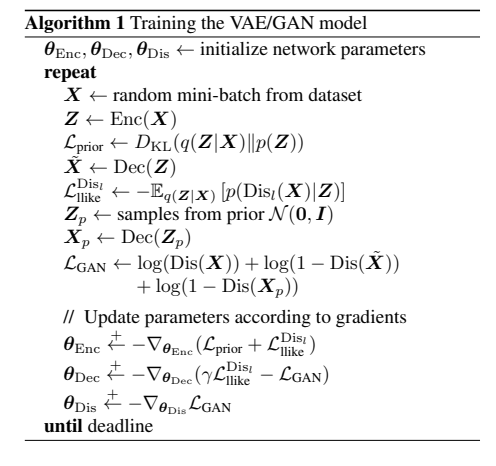

The **VAE** regularizes the encoder by imposing a **prior** over the latent distribution $p(z)$. Thus, it is clear that one goal of the Encoder is to minimize the difference between this latent distribution $p(z)$ and the one described by the model given the data $q(z|x)$.

$$
L_{prior} \leftarrow D_{KL}( q(z|x) || p(z) )
$$

Furthermore, in order to combine both VAE and GAN architectures, the usual VAE reconstruction error term (expected log-likelihood) is replaced here by a **reconstruction error** expressed in the GAN discriminator, introducing a Gaussian observation model at the last layer of the convolutive layers in the Discriminator, namely $p(Dis_l(x)|z)$.

$$
L_{llike}^{Dis_l} \leftarrow - E_{q(z|x)} \{ \log p(Dis_l(x)|z) \}
$$

Then, focusing on the **GAN**, its objective is to find the binary classifier that gives the best possible discrimination between true and generated data, while encouraging the Generator to fit the true data distribution, through the implementation of a min-max game.

$$
L_{GAN} \leftarrow \log ( Dis(x) ) + \log ( 1-Dis(Gen(z)))
$$

Eventually, the combined **VAE-GAN model** is trained using the triple criterion:

$$
L = L_{prior} + L_{llike}^{Dis_l} + L_{GAN}
$$



In [ ]:
'''#############################################################'''
'''################ T R A I N I N G ## S T A G E ###############'''
'''#############################################################'''

# Data Module
visMNIST_data_module.setup('fit')
print('\nNumber of elements in train dataset: {}'.format(len(visMNIST_data_module.train_ds)))
print('Image tensor size: {}'.format(visMNIST_data_module.train_ds.__getitem__(0)[0].size()))
print('EEGrecording tensor size: {}'.format(visMNIST_data_module.train_ds.__getitem__(0)[1].size()))
print('Number of elements in train dataloader: {}'.format(len(visMNIST_data_module.train_dataloader())))
print('\nNumber of elements in val dataset: {}'.format(len(visMNIST_data_module.val_ds)))
print('Image tensor size: {}'.format(visMNIST_data_module.val_ds.__getitem__(0)[0].size()))
print('EEGrecording tensor size: {}'.format(visMNIST_data_module.val_ds.__getitem__(0)[1].size()))
print('Number of elements in val dataloader: {}'.format(len(visMNIST_data_module.val_dataloader())))


# Training and Evaluating the NeuralVisualDecodingfMRIModel Model
trainer_69.fit(model,
               visMNIST_data_module.train_dataloader(),
               visMNIST_data_module.val_dataloader()),
               #ckpt_path='/raid/home/falcigls/NeuralNetworks/DATASET_69/Stuff_NEWTRAIN/TESTS/lightning_logs/version_14/checkpoints/epoch=799-step=36000.ckpt')

print("\n\nFIT DONE\n\n")


## **PREDICTION STAGE**

In [ ]:
'''#############################################################'''
'''############ P R E D I C T I O N ## S T A G E ###############'''
'''#############################################################'''

# Data Module
visMNIST_data_module.setup('predict')
print('Number of elements in test dataset: {}'.format(len(visMNIST_data_module.test_ds)))
print('Image tensor size: {}'.format(visMNIST_data_module.test_ds.__getitem__(0)[0].size()))
print('Number of elements in test dataloader: {}'.format(len(visMNIST_data_module.test_dataloader())))

# Predicting
reconstruction = trainer_69.predict(model, dataloaders=visMNIST_data_module.test_dataloader())

# reconstruction is a list of tensors
print(reconstruction[0][0].size())

for i in range(10):
    image = reconstruction[i][0].squeeze()
    plt.imshow(image, cmap='gray')
    title = '/raid/home/falcigls/NeuralNetworks/DATASET_69/Stuff_NEWTRAIN/Images/reconstruction_{}'.format(i)
    plt.savefig(title)

print("\n\nPREDICT DONE\n\n")


### **PLOTS**

From the plots of our training and validation losses, it is possible to outline some characteristics of the whole framework implemented.

1) The Cognitive Encoder succeeds in mimicking the Visual Encoder (see Training Losses) and also manages to maintain good generalisation performance for unseen data (see Validation Losses). \\
2) Both the generator and the discriminator of our GAN come with noisy gradients, leading to a convergence of our losses anyway. \\
3) The third phase in the training strategy proposed in the reference paper does not allow the model to generalise well to unseen data. For this reason, training was limited to the first two phases, leading to the results shown in the next section.

>

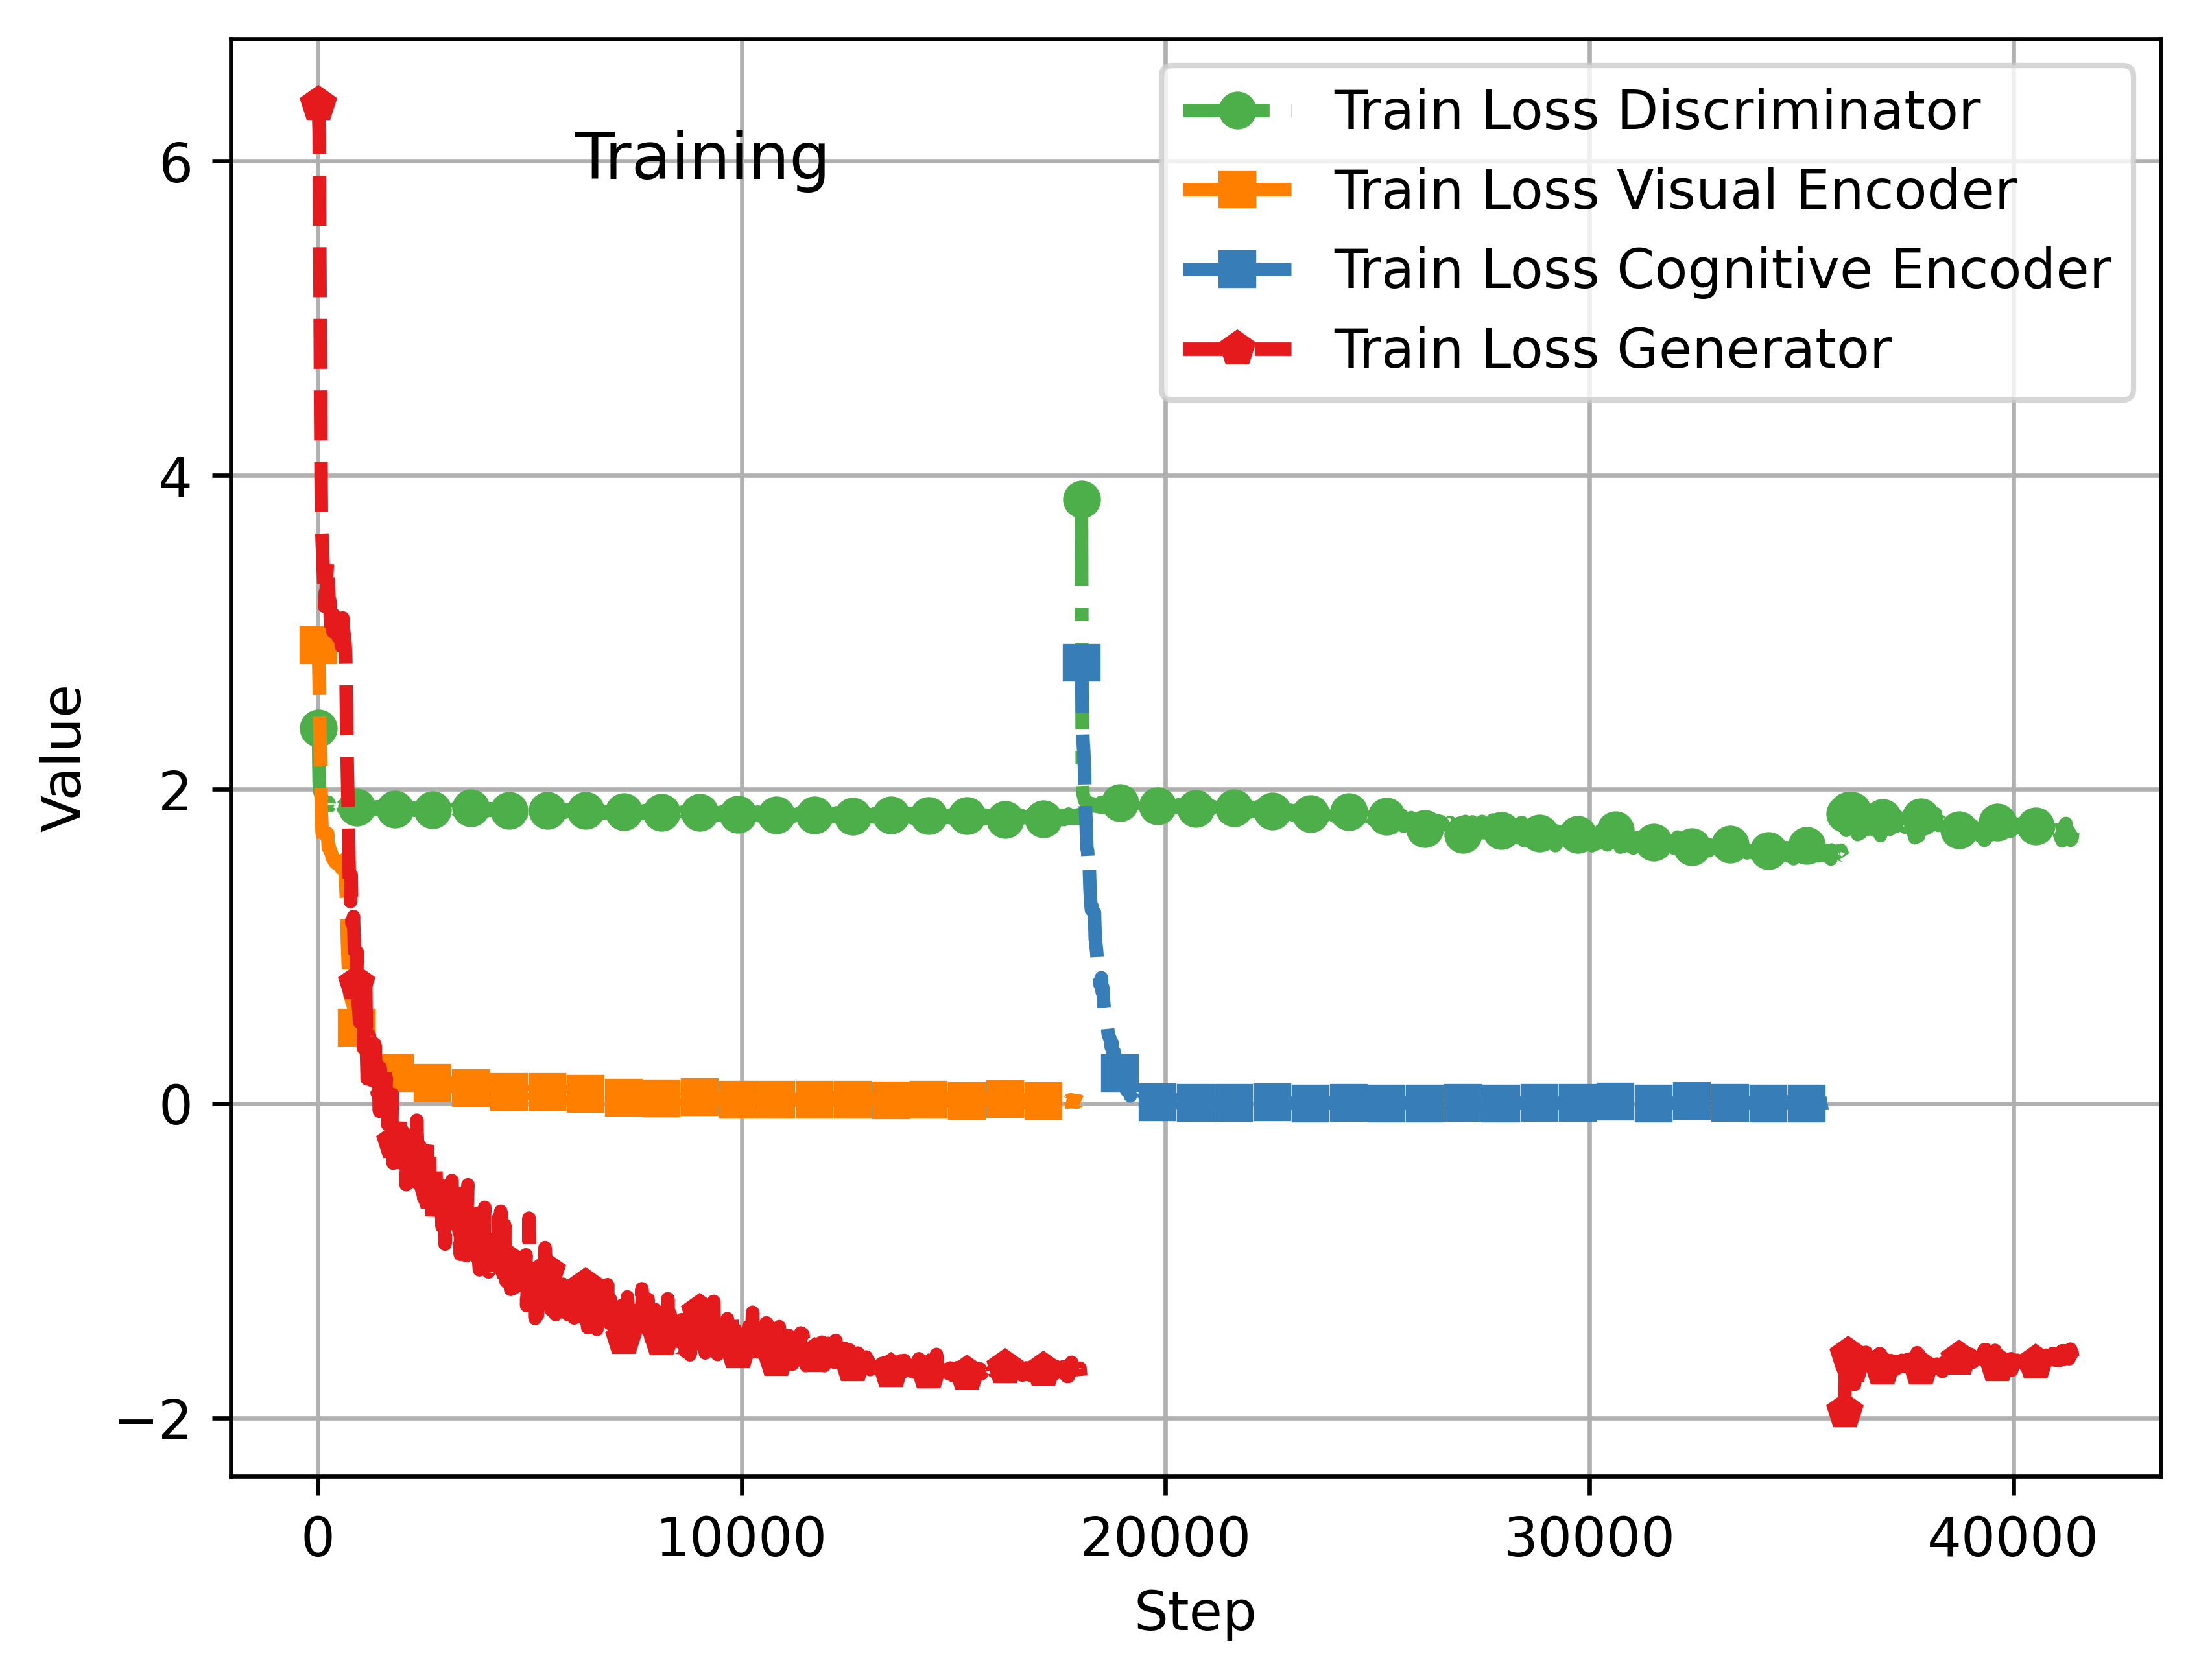

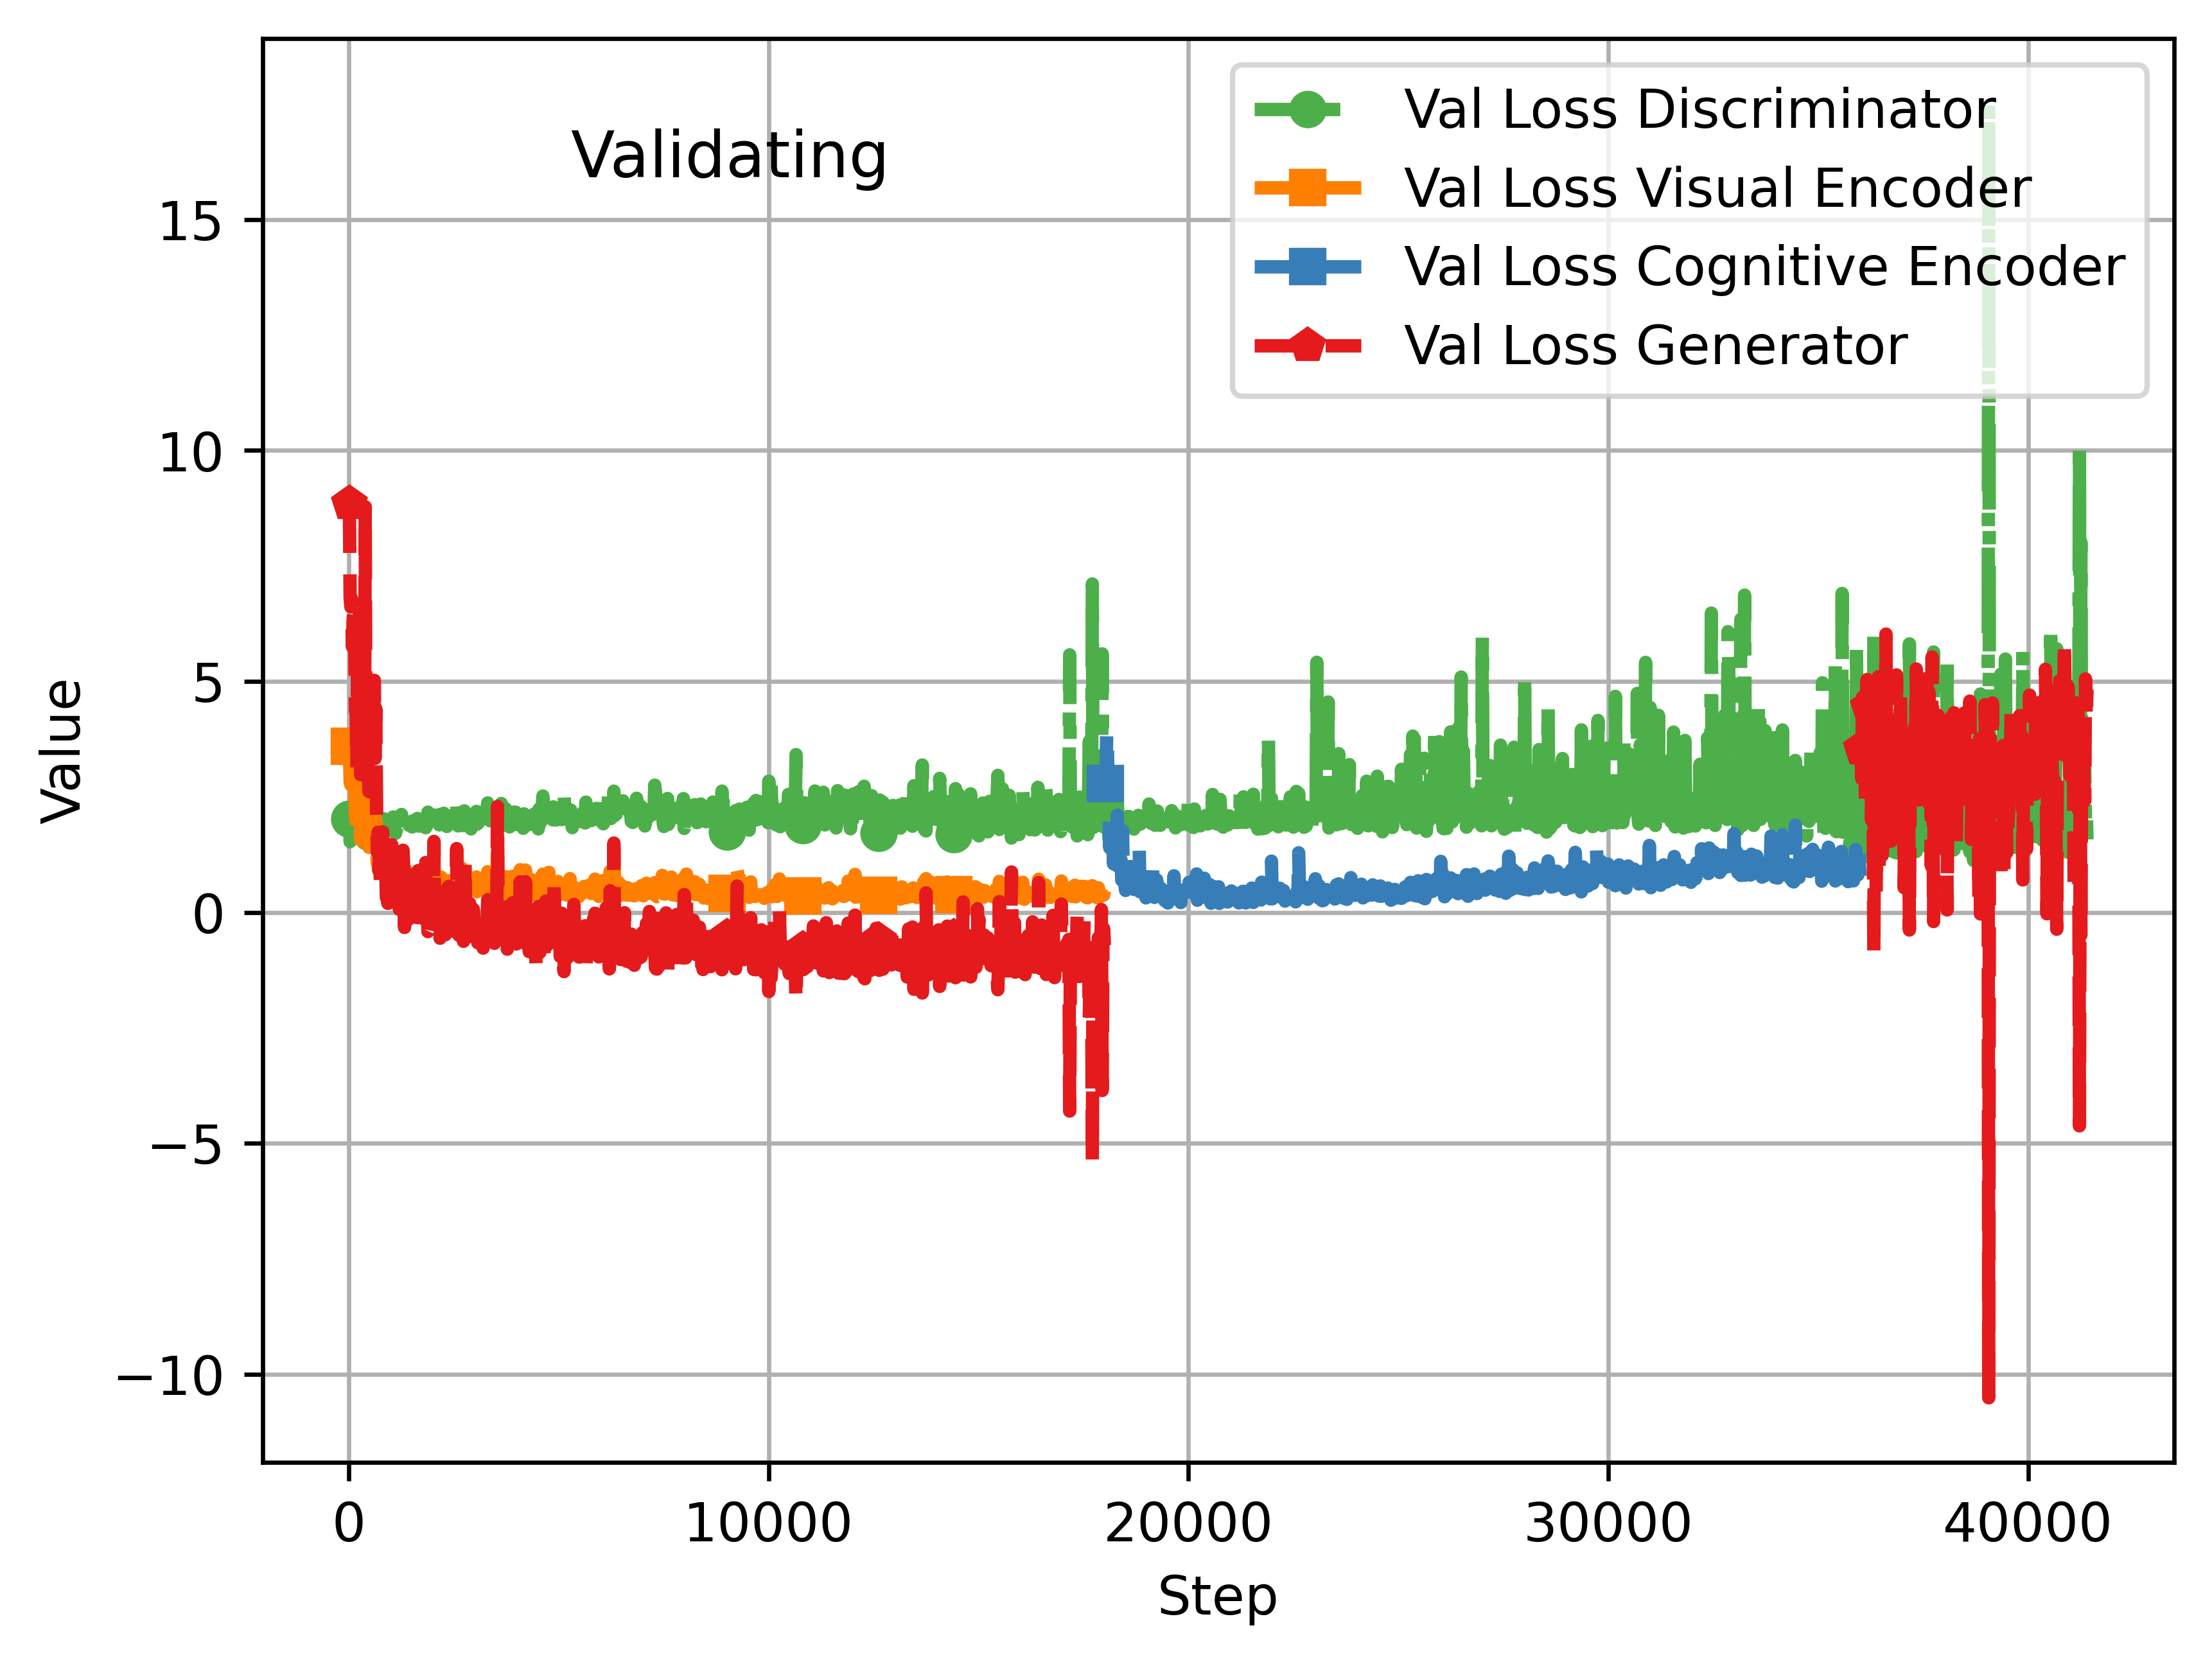

> ### **RESULTS - '69' Dataset**

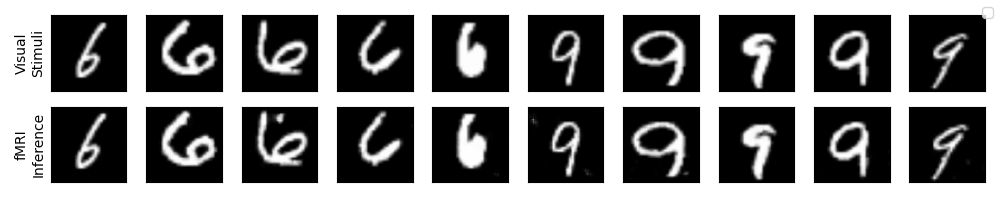

## **EVALUATION METRICS**

To evaluate the performance of the proposed architecture, I used two widely-used metrics in the context of image generation/reconstruction.



1.   **Pearson's Correlation Coefficient (named as Linear Correlation)** \\
The linear relationship between the reconstructed and original images can be evaluated using the Pearson's Correlation Coefficient through making imgaes vectorized and measuring with:

$$
\rho_{X,Y} = \frac{cov(X,Y)}{\sigma_X \sigma_Y} = \frac{E[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X \sigma_Y}
$$

where $\mu_X, \mu_Y$ are the averages of $X$ and $Y$ respectively, \\
$\sigma_X$ and $\sigma_Y$ are the standard deviation of $X$ and $Y$ respectively, \\
$cov(X,Y)$ is the covariance of $X$ and $Y$. \\

2.   **Structural Similarity Index (SSIM)** \\
The strong correlations between the pixels of an image carry important information about the structure of the object in the visual scene. The SSIM index is more consistent with the properties of human vision system (HVS), evaluating the structural similarity between the reconstructed and the original images through the following formula:

$$
SSIM(X,Y) = \frac{(2 \mu_X \mu_Y + c_1)(2 \sigma_{XY} + c_2)}{(\mu_X^2 + \mu_Y^2 + c_1)(\sigma_X^2 + \sigma_Y^2 + c_2)}
$$

where $\mu_X, \mu_Y$ are the averages of $X$ and $Y$ respectively, \\
$\sigma_X^2, \sigma_Y^2$ are the variances of $X$ and $Y$ respectively, \\
$\sigma_{XY}$ is the covariance of $X$ and $Y$, \\
$c_1 = (k_1 L)^2, c_2 = (k_2 L)^2$ used to mantain a stable constant with $k_1=0.001$, $k_2=0.03$, and $L$ the dynamic range of pixel values.



In [ ]:
ssim = StructuralSimilarityIndexMeasure()
for elem in reconstruction:
    pearson_corr = np.corrcoef( elem[0].numpy().reshape(4096) , elem[1].numpy().reshape(4096) )[0][1]
    ssim_corr = ssim( elem[0] , elem[1] )
    print(pearson_corr, ssim_corr)

> ### **RESULTS - '69' Dataset**

$\rho_{img,rcn} = 0.9952 \pm 0.0083$ \\
$SSIM(img,rcn) = 0.9688 \pm 0.0235$

